# GenAI Training
- Original Source Code : <br>
https://github.com/aws-samples/aws-ai-ml-workshop-kr/blob/master/genai/aws-gen-ai-kr/20_applications/02_qa_chatbot/10_hands_on_lab/02_rag_over_complex_pdf/01_rag_over_complex_doc.ipynb

# RAG Process
### - Preprocessing -> Data loading -> Retrieval (Search) -> Augmentation -> Generation

# Part 1. Preprocessing

## 0. Advance preparation

###    1) Install (It's already installed)

In [ ]:
import os
import sys
import IPython
import subprocess


print("installing deps and restarting kernel")
!{sys.executable} -m pip install -U pip
!{sys.executable} -m pip install -U awscli
!{sys.executable} -m pip install -U botocore
!{sys.executable} -m pip install -U boto3
!{sys.executable} -m pip install -U sagemaker 
!{sys.executable} -m pip install -U langchain
!{sys.executable} -m pip install -U langchain-community
!{sys.executable} -m pip install -U langchain_aws
!{sys.executable} -m pip install -U langchain-experimental
!{sys.executable} -m pip install -U termcolor
!{sys.executable} -m pip install -U transformers
!{sys.executable} -m pip install -U opensearch-py
!{sys.executable} -m pip install -U sqlalchemy #==2.0.1
!{sys.executable} -m pip install -U anthropic
!{sys.executable} -m pip install -U pydantic
!{sys.executable} -m pip install -U python-dotenv
!{sys.executable} -m pip install -U llama-parse
!{sys.executable} -m pip install -U pymupdf
!{sys.executable} -m pip install -U pypdf
!{sys.executable} -m pip install -U pdf2image

!sudo yum-config-manager --disable centos-extras
!sudo rpm -Uvh https://dl.fedoraproject.org/pub/epel/epel-release-latest-7.noarch.rpm
!sudo yum -y update
!sudo yum install -y poppler-utils
!{sys.executable} -m pip install -U lxml
!{sys.executable} -m pip install -U kaleido
!{sys.executable} -m pip install -U uvicorn
!{sys.executable} -m pip install -U pandas
!{sys.executable} -m pip install -U numexpr
!sudo sh install_tesseract.sh
!sudo amazon-linux-extras install libreoffice -y
!{sys.executable} -m pip install -U "unstructured[all-docs]"
#!sudo rm -rf leptonica-1.84.1 leptonica-1.84.1.tar.gz tesseract-ocr
!sudo rm -rf leptonica-1.84.1 leptonica-1.84.1.tar.gz tesseract-5.3.1 5.3.1.tar.gz
!sudo yum install -y mesa-libGL


print("Installation process is done!")
IPython.Application.instance().kernel.do_shutdown(True)

installing deps and restarting kernel
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uninstalled python-dateutil-2.9.0.post0
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt_toolkit 3.0.50
    Uninstalling prompt_toolkit-3.0.50:
      Successfully uninstalled prompt_toolkit-3.0.50
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.18.1 requires prompt-toolkit<3.1.0,>=3.0.41, but you have prompt-toolkit 3.0.38 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.

{'status': 'ok', 'restart': True}

: 

## 1. setting

### 1) Please enter the first part of your email address. (Ex. ABC@megazone.com -> ABC)

In [ ]:
# An index will be created with that name.
# Use only lowercase alphabetic characters and -(dash) and _(underscore)
user_mail = "[EMAIL or ANY UNIQUE NAME]"

### 2) Environment Sestting

In [2]:
#bedrock
bedrock_endpoint_url = "https://bedrock-runtime.ap-northeast-2.amazonaws.com" # ex) "https://vpce~~~~~~~~.bedrock-runtime.ap-northeast-1.vpce.amazonaws.com"
bedrock_region_name = 'ap-northeast-2' # Seoul

#os
os_host = 'vpc-os-domain-for-mzcvn-rxxqxep7xsbgbpzptd6zplbkoq.ap-northeast-2.es.amazonaws.com' # ex) 'vpc~~~~~~.ap-northeast-2.es.amazonaws.com'
os_region = 'ap-northeast-2' # Seoul
os_auth = ("admin", "Mzcvn123!@#")

## 2. Data Parsing
### - Extract text, tables, and image data from source documents (PDFs) using Unstructured.io

In [3]:
import sys, os
import shutil
from glob import glob
from unstructured.cleaners.core import clean_bullets, clean_extra_whitespace
from langchain_community.document_loaders import UnstructuredFileLoader, UnstructuredAPIFileLoader

In [4]:
pdf_file_path = '/home/ec2-user/data/Virtual try-on - Amazon Nova.pdf' # Full path including file format
pdf_img_path = "./images" # Path where the extracted image will be saved

# Create an image folder (delete if it already exists and create it)
if os.path.isdir(pdf_img_path):
    shutil.rmtree(pdf_img_path)
    
os.mkdir(pdf_img_path)

# File loader declaration
loader = UnstructuredFileLoader(
    # PDF file path
    file_path=pdf_file_path,
    
    # Chunking strategy
    chunking_strategy = "by_title",
    mode="elements",
    # single: Returns as a single object
    # elements: Split the document into elements such as Title, and return the langchain Document as individual objects.

    # High-resolution analysis strategy
    strategy="hi_res", # fast
    hi_res_model_name="yolox", #"detectron2_onnx", "yolox", "yolox_quantized"

    # Whether to extract images from PDF
    extract_images_in_pdf=True,
    skip_infer_table_types=[], # ['pdf', 'jpg', 'png', 'xls', 'xlsx', 'heic']

    # Select the path where the extracted image will be saved
    extract_image_block_output_dir=pdf_img_path,
    
    # Extracted images are stored on disk, not in memory.
    extract_image_block_to_payload=False,

    
    # Maximum character length of each chunk
    max_characters=4096,
    # Create a new chunk when it exceeds 4000 characters
    new_after_n_chars=4000,
    # Combine with other chunks if less than 2000 characters
    combine_text_under_n_chars=2000,

    # language
    languages= ["kor+eng"],

    # Postprocessor
    # clean_bullets : Remove unnecessary bullets
    # clean_extra_whitespace : Remove extra spaces
    post_processors=[clean_bullets, clean_extra_whitespace]
)

/tmp/ipykernel_4795/497384139.py:11: LangChainDeprecationWarning: The class `UnstructuredFileLoader` was deprecated in LangChain 0.2.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-unstructured package and should be used instead. To use it run `pip install -U :class:`~langchain-unstructured` and import as `from :class:`~langchain_unstructured import UnstructuredLoader``.
  loader = UnstructuredFileLoader(


In [5]:
%%time

# Load (extract) document data via file loader
pdf_docs = loader.load()

CPU times: user 26.3 s, sys: 1.51 s, total: 27.9 s
Wall time: 42.6 s


In [6]:
from pprint import pprint

pprint(pdf_docs[0].page_content)

('25. 8. 19. 오전 9:36 Virtual try-on - Amazon Nova '
 'n.com/contact-us/?cmpid=docs_headercta_contactus) '
 'dden_service_name=Bedrock&topic_url=https://docs.aws.amazon.com/nova/latest/userguide/image-gen-vto.html) '
 'Get started Service guides Developer too (https://docs.aws.amazon.com) (#) '
 '(#) (#) = Documentation (https://docs.aws.amazon.com/index.html) > Amazon '
 'Nova (https://docs.aws.amazon.com/nova/index.html) Virtual try-on PDF '
 '(/pdfs/nova/latest/userguide/nova-ug.pdf#image-gen-vto) & RSS (nova-ug.rss) '
 'Focus mode 슈 Virtual try-on is an image-guided use case of inpainting in '
 'which the contents of a reference image are superimposed into a source image '
 'based on the guidance of a mask image. Amazon Nova Canvas has been tuned for '
 'garments, accessories, furniture, and related objects. The model also '
 'generalizes well to other cases, such as adding a logo or text into an '
 'image. You can generate up to ﬁve images with the virtual try-on API. By '
 'defaul

In [7]:
pprint(pdf_docs[0].metadata)

{'category': 'CompositeElement',
 'element_id': '4a19f0cbf663fe20141b5b79604a5f42',
 'file_directory': '/home/ec2-user/data',
 'filename': 'Virtual try-on - Amazon Nova.pdf',
 'filetype': 'application/pdf',
 'languages': ['kor', 'eng'],
 'last_modified': '2025-08-19T01:20:10',
 'orig_elements': 'eJzdWwtv20YS/iuECxQp4JX3/QiQO7RX9FrgWuSa9IBDGhj7os1GEgWSsuMW999vdkkqki3nbOUYGTVgQTPaXZLz/GZ2+eaPkziPi7jszqtw8rw4MVZaJrBBmHCLeKQUGcowChwT4YVxnrKT0+JkETsbbGdhzh8nvq6bUC1tF9tMz+1Nve7OL2N1cdkBhzJmYM7Avq5CdwlcIgUD7qqull2a9+aNZDNxWnA2k29Pi4GSpqco1zN+h8xjgT5pb9ouLtITvKzex/mrlfXx5D/wQ4hd9F1VL8/93Lbt+aqpHQzDM82ZkTCgrOaxu1nFPPfljyf5RpcXa3uRn+bNybu6Scy4vDh5m39su/NFHaqyillkFFOBsEbEvMbkOcXPCU7jV7DA+XK9cLFJD5vupYvvuzxDzAo9K4iZFb+uvaQcPjXmhXnOZJo63s730QaYDVNvq0lpg7WTDpXEgZoMDUhzHJAR2mpBnaIhTKYmTckMBnIxI0kVAyl1TxJs4Ie7dB5+mKqUIYYcR1X/qppubedF19ygelmg4uuF/R2+/FRf2YepynLuuCcWSa094qTkCFQUkfPEC06MiUZPpiolZvq0oKMuBtLIGc0kWKDYQ+fhh6lKYo7pcVS1nPl6cebrZWd9h9bt2V/9YlWFF6H2LUgu6cd39nwYsG6/2tbfT7ZpbFddxddptX1qVFF5ET3SLID

In [8]:
tables, texts = [], []

for doc in pdf_docs:

    category = doc.metadata["category"]
    if category == "Table": tables.append(doc)
    elif category == "Image": images.append(doc)
    else: texts.append(doc)
    
    images = glob(os.path.join(pdf_img_path, "*"))

print (f' # texts: {len(texts)} \n # tables: {len(tables)} \n # images: {len(images)}')

 # texts: 4 
 # tables: 0 
 # images: 3


In [9]:
images

['./images/figure-2-1.jpg',
 './images/figure-2-2.jpg',
 './images/figure-2-3.jpg']

## 3. Data Preprocessing

### 1) Calling the Bedrock model

In [10]:
# LLM Load
import json
import boto3
from pprint import pprint
from termcolor import colored
from langchain_aws import ChatBedrock, BedrockEmbeddings
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler


boto3_bedrock = boto3.client('bedrock-runtime', region_name = bedrock_region_name, endpoint_url = bedrock_endpoint_url)



llm_text = ChatBedrock(
    model_id="anthropic.claude-3-5-sonnet-20240620-v1:0",
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        # Maximum number of tokens
        "max_tokens": 2048,
        # Stop generation keyword
        "stop_sequences": ["\n\nHuman"],
        # Output diversity control
        "temperature": 0.1, # creativity
        "top_k": 250, # Nearby 250 words
        "top_p": 0.9 # Sum of probability values
    }
)
print("LLM ::: Bedrock Claude 3.5 Sonnet Load")

llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id="amazon.titan-embed-text-v2:0"
)
dimension = 1024 #1536
print("Embedding Model ::: Bedrock Titan v2 Load")

LLM ::: Bedrock Claude 3.5 Sonnet Load
Embedding Model ::: Bedrock Titan v2 Load


In [11]:
llm_text.invoke("Hello")

Hello! How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything.

AIMessage(content='Hello! How can I assist you today? Feel free to ask me any questions or let me know if you need help with anything.', additional_kwargs={}, response_metadata={'stop_reason': 'stop_sequence', 'stop_sequence': '\n\nHuman'}, id='run-66ba2d4e-5bca-46c0-9716-e6d33413014c-0', usage_metadata={'input_tokens': 8, 'output_tokens': 29, 'total_tokens': 37})

In [12]:
llm_emb.embed_query("Hello")

[-0.0635838583111763,
 0.05780351161956787,
 0.02563459984958172,
 0.006785629317164421,
 0.04925864562392235,
 -0.04775072634220123,
 0.012000511400401592,
 0.020859528332948685,
 0.014576537534594536,
 0.0007068364066071808,
 -0.010304104536771774,
 0.05152051895856857,
 0.010366934351623058,
 -0.05302843824028969,
 -0.010429764166474342,
 -0.032168909907341,
 -0.01683841459453106,
 -0.028273455798625946,
 0.0608193464577198,
 0.00590601097792387,
 -0.024126682430505753,
 0.02111084759235382,
 0.030284013599157333,
 -0.018848970532417297,
 -0.03995981812477112,
 -0.020356887951493263,
 -0.030660992488265038,
 -0.03820057958364487,
 0.0069741192273795605,
 -0.07036948949098587,
 0.056295592337846756,
 0.0160844549536705,
 -0.010052784346044064,
 -0.007476758677512407,
 0.003015835303813219,
 0.06182462349534035,
 0.025383280590176582,
 -0.012000511400401592,
 -0.012063341215252876,
 -0.007979397661983967,
 0.05554163455963135,
 -0.023372724652290344,
 -0.0061573307029902935,
 0.025383

### 2) Image reconstruction

#### 2-1) Image size conversion

In [13]:
# When using an image as input for LLM, costs are incurred depending on the size of the image.
# You can save money by reducing the size of your images below a certain level.
# Compensate for errors that occur during table parsing by working with tables in image format.

import os
from io import BytesIO
import cv2
import math
import base64
import numpy as np
from PIL import Image
from pdf2image import convert_from_path

def image_to_base64(image_path):
    
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        
    return encoded_string.decode('utf-8')

def crop_and_resize_image(image):
    # Image size measurement
    width, height = image.size
    image_token = width * height / 750

    # Apply crop and resize conditions
    if image_token > 1500:
        # Applying the same 0.5x reduction ratio as cv2
        new_width = int(width * 0.5)
        new_height = int(height * 0.5)
        image = image.resize((new_width, new_height), Image.LANCZOS)

    return image



image_tmp_path = os.path.join(pdf_img_path, "tmp")
if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
os.mkdir(image_tmp_path)

# from pdf to image
pages = convert_from_path(pdf_file_path)
for i, page in enumerate(pages):
    print (f'pdf page {i}, size: {page.size}')    
    page.save(f'{image_tmp_path}/{str(i+1)}.jpg', "JPEG")

print ("==")    

for idx, image_path in enumerate(images):
    img = Image.open(image_path).convert('RGB')

    resized_img = crop_and_resize_image(img)
    resized_img.save(image_path)

if os.path.isdir(image_tmp_path): shutil.rmtree(image_tmp_path)
    
images = glob(os.path.join(pdf_img_path, "*"))
print (f'images: {images}')

pdf page 0, size: (1653, 2339)
pdf page 1, size: (1653, 2339)
pdf page 2, size: (1653, 2339)
pdf page 3, size: (1653, 2339)
pdf page 4, size: (1653, 2339)
==
images: ['./images/figure-2-1.jpg', './images/figure-2-2.jpg', './images/figure-2-3.jpg']


#### 2-2) Convert image to text

In [14]:
# Image Summary
# Converts images into text format for searchability.

from langchain.schema import Document
from langchain_core.messages import HumanMessage
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

system_prompt = """
                Your job is to convert information contained in an image into text.
                Please describe in detail what the provided image represents.
                Do not include any tags in your answer.
            """
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)

In [15]:
# Image Summary

import time
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import botocore


human_prompt = [
    {
        "type": "image_url",
        "image_url": {
            "url": "data:image/png;base64," + "{image_base64}",
        },
    },
    {
        "type": "text",
        "text": '''
        '''
    },
]
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)


prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        human_message_template
    ]
)
# Confirm prompt
pprint(prompt)

summarize_chain = prompt | llm_text | StrOutputParser()
print("")
pprint(summarize_chain)

ChatPromptTemplate(input_variables=['image_base64'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='\n                Your job is to convert information contained in an image into text.\n                Please describe in detail what the provided image represents.\n                Do not include any tags in your answer.\n            '), additional_kwargs={}), HumanMessagePromptTemplate(prompt=[ImagePromptTemplate(input_variables=['image_base64'], input_types={}, partial_variables={}, template={'url': 'data:image/png;base64,{image_base64}'}), PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='\n        ')], additional_kwargs={})])

ChatPromptTemplate(input_variables=['image_base64'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, t

In [16]:
# Encode the image to Base64
img_info = [image_to_base64(img_path) for img_path in images if os.path.basename(img_path).startswith("figure")]

# Summary function
def summary_img(summarize_chain, img_base64):
    # Output image on screen
    img = Image.open(BytesIO(base64.b64decode(img_base64)))
    plt.imshow(img)
    plt.show()
    # Summary execution
    summary = summarize_chain.invoke(
        {
            "image_base64": img_base64
        }
    )

    return summary

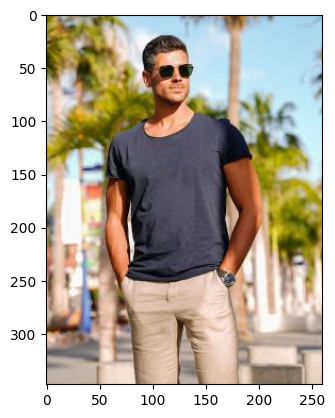

The image shows a man standing outdoors in a sunny, tropical setting. He's wearing a dark gray t-shirt and light-colored khaki or beige pants. The man has on sunglasses and appears to have short, dark hair. His posture is relaxed, with one hand in his pocket.

In the background, there are several palm trees, indicating a warm climate location, possibly a beach town or resort area. The lighting suggests it's a bright, sunny day. The overall atmosphere of the image conveys a casual, vacation-like vibe.

The man's attire and surroundings suggest a blend of casual style and a leisurely environment, typical of a warm, tourist-friendly destination.
==
0


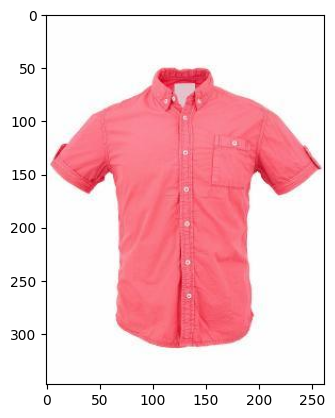

The image shows a short-sleeved button-up shirt in a vibrant coral or salmon pink color. The shirt has a classic collar with button-down points, giving it a casual yet neat appearance. There's a single chest pocket on the left side, adding a functional detail to the design. The sleeves appear to be slightly rolled or cuffed at the ends. The fabric looks to be a lightweight material, possibly cotton or a cotton blend, suitable for warm weather. The shirt's bright color makes it a standout piece that would be perfect for spring or summer casual wear. The overall style of the shirt suggests a relaxed, preppy aesthetic that could be versatile for various casual occasions.
==
1


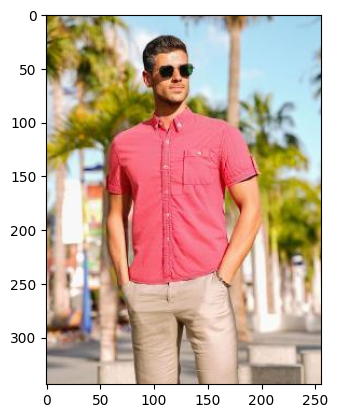

The image shows a man standing outdoors in a tropical or beach-like setting. He's wearing a bright coral or salmon-colored short-sleeved button-up shirt with a collar. The shirt has a pocket on the chest. He's paired this with light khaki or beige pants.

The man is wearing dark sunglasses and has short, dark hair styled neatly. His posture is relaxed, with one hand in his pocket.

In the background, you can see palm trees lining what appears to be a street or walkway, suggesting a warm climate location, possibly a resort area or beachfront promenade.

The lighting in the image is bright and sunny, typical of a clear day in a warm climate. The overall atmosphere of the image conveys a casual, vacation-like vibe.
==
2


In [17]:
image_summaries = []
for idx, img_base64 in enumerate(img_info):
    summary = summary_img(summarize_chain, img_base64)
    image_summaries.append(summary)
    print ("\n==")
    print (idx)

In [18]:
images_preprocessed = []

for img_path, image_base64, summary in zip(images, img_info, image_summaries):
    
    metadata = {}
    metadata["img_path"] = img_path
    metadata["category"] = "Image"
    metadata["image_base64"] = image_base64
    
    doc = Document(
        page_content=summary,
        metadata=metadata
    )
    images_preprocessed.append(doc)

In [19]:
# Final image verification
images_preprocessed[0].page_content

"The image shows a man standing outdoors in a sunny, tropical setting. He's wearing a dark gray t-shirt and light-colored khaki or beige pants. The man has on sunglasses and appears to have short, dark hair. His posture is relaxed, with one hand in his pocket.\n\nIn the background, there are several palm trees, indicating a warm climate location, possibly a beach town or resort area. The lighting suggests it's a bright, sunny day. The overall atmosphere of the image conveys a casual, vacation-like vibe.\n\nThe man's attire and surroundings suggest a blend of casual style and a leisurely environment, typical of a warm, tourist-friendly destination."

-------------------
-------------------
-------------------
-------------------
-------------------
# Part 2. RAG

## 1. Data Loading

### 1) Creating an OpenSearch index

In [20]:
# Create OS connection
from opensearchpy import OpenSearch,RequestsHttpConnection, AWSV4SignerAuth

host = os_host
region = os_region
service = "es"
auth = os_auth


# OpenSearch client settings
os_client = OpenSearch(
    hosts = [{'host': host, 'port': 443}],
    http_auth = auth,
    use_ssl = True,
    verify_certs = True,
    connection_class = RequestsHttpConnection,
    pool_maxsize = 20,
    timeout=30
)

In [ ]:
# Index configuration information
index_name = user_mail
index_body = {
    'settings': {
        'analysis': {
            # analyzer settings
            'analyzer': {
                'my_analyzer': {
                    'char_filter':['html_strip'],
                    'tokenizer': 'standard',
                    'filter': [
                        'my_stop'
                    ],
                    'type': 'custom'
                }
            },
            # Add a filter to use in the analyzer.
            "filter": {
                "my_stop": {
                    "type": "stop",
                    "stopwords": ["a", "an", "to", "for", "by", "on", "the", "of", "and"] 
                }
            }
        },
        # The index uses KNN (Vector search).
        'index': {
            'knn': True,
            'knn.space_type': 'cosinesimil'  # Example space type
        }
    },
    # Column Information
    'mappings': {
        'properties': {
            'metadata': {
                'properties': {
                    'source': {'type': 'keyword'},
                    'page_number': {'type':'long'},
                    'category': {'type':'text'},
                    'file_directory': {'type':'text'},
                    'last_modified': {'type': 'text'},
                    'type': {'type': 'keyword'},
                    'image_base64': {'type':'text'},
                    'origin_image': {'type':'text'},
                    'origin_table': {'type':'text'},
                }
            },
            # This is the field where you will perform a text search.
            'text': {
                'analyzer': 'my_analyzer',
                'search_analyzer': 'my_analyzer',
                'type': 'text'
            },
            # This is the field where Vector Search will be performed.
            'vector_field': {
                'type': 'knn_vector',
                'dimension': f"{dimension}" 
            }
        }
    }
}

In [48]:
from utils.opensearch import opensearch_utils

# Checks if an index with the same name already exists. If an index already exists, an error occurs.
index_exists = opensearch_utils.check_if_index_exists(
    os_client,
    index_name
)

# # If you uncomment and run the command below, it will delete the index with the same name and create a new one.
# if index_exists:
#     opensearch_utils.delete_index(
#         os_client,
#         index_name
#     )

opensearch_utils.create_index(os_client, index_name, index_body)

index_name=mzcvn-test-index, exists=True

Deleting index:
{'acknowledged': True}



Creating index:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'mzcvn-test-index'}


In [49]:
# Check the created index information.
index_info = os_client.indices.get(index=index_name)
print("Index is created")
pprint(index_info)

Index is created
{'mzcvn-test-index': {'aliases': {},
                      'mappings': {'properties': {'metadata': {'properties': {'category': {'type': 'text'},
                                                                              'file_directory': {'type': 'text'},
                                                                              'image_base64': {'type': 'text'},
                                                                              'last_modified': {'type': 'text'},
                                                                              'origin_image': {'type': 'text'},
                                                                              'origin_table': {'type': 'text'},
                                                                              'page_number': {'type': 'long'},
                                                                              'source': {'type': 'keyword'},
                                                       

In [50]:
# Test the Analyzer.
text = "Robots move their bodies, create data directly on site, and learn on the spot."
response = os_client.indices.analyze(
    index=index_name,  # Index name to use for analysis
    body={
        "analyzer": "my_analyzer",  # The name of the analyzer you set
        "text": text
    }
)

# Output results
print("Tokenization results:")
for token in response.get("tokens", []):
    print(f"Token: {token['token']}")

Tokenization results:
Token: Robots
Token: move
Token: their
Token: bodies
Token: create
Token: data
Token: directly
Token: site
Token: learn
Token: spot


In [51]:
# Vectorized sample.
text = "Robots move their bodies, create data directly on site, and learn on the spot."

# Embedding text
embeddings = llm_emb.embed_documents(text)

# Output results
print(f"dimension: {len(embeddings[0])}")
print(embeddings[0])

dimension: 1024
[-0.049075085669755936, 0.001358110224828124, 0.015503820963203907, 0.0463893860578537, -0.06055035442113876, 0.005523999221622944, 0.011963577941060066, 0.021607687696814537, -0.010376572608947754, -0.011536307632923126, -0.018433677032589912, 0.03271672502160072, 0.002472065854817629, -0.005798673257231712, 0.029664790257811546, -0.012451887130737305, -0.01770121231675148, -0.028932327404618263, 0.03833227977156639, -0.007935026660561562, 0.061282817274332047, 0.02404923364520073, 0.03149595111608505, -0.009949302300810814, -0.02404923364520073, 0.032228413969278336, -0.02319469302892685, -0.017579134553670883, 0.0756879448890686, -0.027955707162618637, 0.024171311408281326, -0.0017853808822110295, 0.005920750554651022, 0.030885564163327217, 0.012757080607116222, -0.003860695520415902, 0.020875222980976105, -0.02270638197660446, 0.04834262281656265, -0.025514161214232445, -0.0014191488735377789, -0.03112971782684326, -0.005981788970530033, 0.013977853581309319, 0.0014

### 2) Data Loading

#### 2-1) Parent data loading

In [52]:
# Load parent data into OpenSearch.
from utils.chunk import parant_documents

parent_chunk_size = 4096
parent_chunk_overlap = 0

child_chunk_size = 1024
child_chunk_overlap = 256

opensearch_parent_key_name = "parent_id"
opensearch_family_tree_key_name = "family_tree"

parent_chunk_docs = parant_documents.create_parent_chunk(
    docs=texts, # Perform text extraction on the target value
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name,
    parent_chunk_size=parent_chunk_size,
    parent_chunk_overlap=parent_chunk_overlap
)
# Check the parent document
print(f'Number of Parent Documents = {len(parent_chunk_docs)}')
pprint(parent_chunk_docs[0].page_content)

Number of Parent Documents = 4
('25. 8. 19. 오전 9:36 Virtual try-on - Amazon Nova '
 'n.com/contact-us/?cmpid=docs_headercta_contactus) '
 'dden_service_name=Bedrock&topic_url=https://docs.aws.amazon.com/nova/latest/userguide/image-gen-vto.html) '
 'Get started Service guides Developer too (https://docs.aws.amazon.com) (#) '
 '(#) (#) = Documentation (https://docs.aws.amazon.com/index.html) > Amazon '
 'Nova (https://docs.aws.amazon.com/nova/index.html) Virtual try-on PDF '
 '(/pdfs/nova/latest/userguide/nova-ug.pdf#image-gen-vto) & RSS (nova-ug.rss) '
 'Focus mode 슈 Virtual try-on is an image-guided use case of inpainting in '
 'which the contents of a reference image are superimposed into a source image '
 'based on the guidance of a mask image. Amazon Nova Canvas has been tuned for '
 'garments, accessories, furniture, and related objects. The model also '
 'generalizes well to other cases, such as adding a logo or text into an '
 'image. You can generate up to ﬁve images with the vi

In [53]:
from langchain.vectorstores import OpenSearchVectorSearch

# Setting up an OpenSearch connection
opensearch_url = 'https://' + host + ':443'
auth = os_auth

vector_db = OpenSearchVectorSearch(
    index_name=index_name,
    opensearch_url=opensearch_url,
    embedding_function=llm_emb,
    http_auth=auth, # http_auth
    is_aoss=False,
    engine="faiss",
    space_type="l2",
    bulk_size=100000,
    timeout=60
)

In [54]:
%%time
# Loading Parents Document
parent_ids = vector_db.add_documents(
    documents = parent_chunk_docs, 
    vector_field = "vector_field",
    bulk_size = 1000000
)

CPU times: user 35.6 ms, sys: 9.76 ms, total: 45.4 ms
Wall time: 485 ms


In [55]:
# Check that the loading has been done normally.
from utils.opensearch import opensearch_utils

total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("Number of loaded documents: ", total_count_docs)

Number of loaded documents:  {'count': 4, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


#### 2-2) Loading Child Data

In [56]:
# Create a child document
child_chunk_docs = parant_documents.create_child_chunk(
    child_chunk_size=child_chunk_size,
    child_chunk_overlap=child_chunk_overlap,
    docs=parent_chunk_docs,
    parent_ids_value=parent_ids,
    parent_id_key=opensearch_parent_key_name,
    family_tree_id_key=opensearch_family_tree_key_name
)

In [57]:
# Check the contents of the Child document
print(f"Number of child documents = {len(child_chunk_docs)}")
pprint(child_chunk_docs[0].page_content)

Number of child documents = 13
('25. 8. 19. 오전 9:36 Virtual try-on - Amazon Nova '
 'n.com/contact-us/?cmpid=docs_headercta_contactus) '
 'dden_service_name=Bedrock&topic_url=https://docs.aws.amazon.com/nova/latest/userguide/image-gen-vto.html) '
 'Get started Service guides Developer too (https://docs.aws.amazon.com) (#) '
 '(#) (#) = Documentation (https://docs.aws.amazon.com/index.html) > Amazon '
 'Nova (https://docs.aws.amazon.com/nova/index.html) Virtual try-on PDF '
 '(/pdfs/nova/latest/userguide/nova-ug.pdf#image-gen-vto) & RSS (nova-ug.rss) '
 'Focus mode 슈 Virtual try-on is an image-guided use case of inpainting in '
 'which the contents of a reference image are superimposed into a source image '
 'based on the guidance of a mask image. Amazon Nova Canvas has been tuned for '
 'garments, accessories, furniture, and related objects. The model also '
 'generalizes well to other cases, such as adding a logo or text into an '
 'image. You can generate up to ﬁve images with the vi

In [58]:
%%time

child_ids = vector_db.add_documents(
    documents=child_chunk_docs, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("Number of loaded documents: ", len(child_ids))

Number of loaded documents:  13
CPU times: user 68.7 ms, sys: 0 ns, total: 68.7 ms
Wall time: 1.03 s


In [59]:
# Check if the child document loading was successful.
from utils.opensearch import opensearch_utils

total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("Number of loaded documents: ", total_count_docs)

Number of loaded documents:  {'count': 17, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


#### 2-3) Loading image data

In [60]:
for image in images_preprocessed:
    image.metadata["family_tree"], image.metadata["parent_id"] = "parent_image", "NA"

In [61]:
images_preprocessed[0].metadata

{'img_path': './images/figure-2-1.jpg',
 'category': 'Image',
 'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFcAQQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwCnpUEt80ayFlQetb8k62V7DAqsYx1JqCO+t7BxGnzcYVQOaq6pczzZYDax5FfNYas6U77neqftItGrqN0t8yrFE7bR

In [62]:
%%time

img_ids = vector_db.add_documents(
    documents=images_preprocessed, 
    vector_field = "vector_field",
    bulk_size=1000000
)

print("Number of loaded documents: ", len(img_ids))

Number of loaded documents:  3
CPU times: user 22.7 ms, sys: 0 ns, total: 22.7 ms
Wall time: 695 ms


In [63]:
# Finally, check whether the loading was successful.
from utils.opensearch import opensearch_utils

total_count_docs = opensearch_utils.get_count(os_client, index_name)
print("Number of loaded documents: ", total_count_docs)

Number of loaded documents:  {'count': 20, '_shards': {'total': 5, 'successful': 5, 'skipped': 0, 'failed': 0}}


## 2. Retrieval (Search)

### 1) Lexical Search (Text Search , Keyword Search)

In [64]:
# Enter your usage question
from utils.rag import retriever_utils
text_query = "How to generate new poses?"

In [65]:
# Analyzer Test
# The question you entered earlier will be tokenized and searched as follows:
response = os_client.indices.analyze(
    index=index_name,  # Index name to use for analysis
    body={
        "analyzer": "my_analyzer",  # The name of the analyzer you set
        "text": text_query
    }
)

# Output results
print("Tokenization results:")
token_list = []
for token in response.get("tokens", []):
    print(f"Token: {token['token']}")
    token_list.append(token['token'])

Tokenization results:
Token: How
Token: generate
Token: new
Token: poses


In [67]:
# Search
results = retriever_utils().get_lexical_similar_docs(
    query=text_query, 
    k=3, 
    os_client=os_client, 
    index_name = index_name,
    filter=[]
)
#results[0].page_content
show_text_result = results[0].page_content
# Add color
red_start = "\033[31m"  # Red color start
color_reset = "\033[0m"  # Reset color

# Apply color to only specific parts of text
for highlight in token_list:
    show_text_result = show_text_result.replace(highlight, f"{red_start}{highlight}{color_reset}")
print(show_text_result)

. "UNTUCKED" - Can be applied regardless of whether the source image has the shirt tucked or untucked. "TUCKED" - Can be applied when the source image has the shirt tucked in. "outerLayerStyle" - Controls whether an upper body garment is styled open or closed. This defaults to "CLOSED" which is appropriate https://docs.aws.amazon.com/nova/latest/userguide/image-gen-vto.html 4/5 25. 8. 19. 오전 9:36 Virtual try-on - Amazon Nova for most garments (such as shirts and sweaters). For outer garments, like jackets, setting this value to "OPEN" guarantees that the original upper body garment from the source image will be retained with the new outer garment being layered over it. Using a value of "CLOSED" with an outer garment might not always render the garment as closed. This is because a value of "CLOSED" only guarantees that every upper body garment in the source image will be replaced and can sometimes result in an open outer layer with a new under layer visible beneath


### 2) Semantic Search (Vector Search)

In [68]:
# Text embedding
embeddings = llm_emb.embed_documents(text_query)

# result
print(f"Dimension: {len(embeddings[0])}")
print(embeddings[0])

Dimension: 1024
[-0.05109311267733574, 0.04282089322805405, -0.018004238605499268, -0.022870250046253204, 0.008819644339382648, -0.01082687359303236, -0.0347919762134552, 0.022870250046253204, 0.006508289370685816, -0.03649507835507393, -0.015692884102463722, -0.005930450279265642, 0.008272218517959118, 0.009792846627533436, 0.0017183100571855903, -0.0046835350804030895, -0.015388758853077888, -0.019950643181800842, -0.0005360214854590595, -0.014354731887578964, 0.021897047758102417, 0.05936532840132713, -0.0008895676000975072, 0.0020072294864803553, 0.000480898714158684, 0.004744360223412514, 0.027857910841703415, -0.0020528482273221016, -0.009610370732843876, -0.004440234508365393, 0.014233081601560116, 0.010461922734975815, 0.020072294399142265, -0.03649507835507393, 0.036738380789756775, 0.01946404203772545, -0.005291786510497332, -0.023478500545024872, -0.05668902397155762, 0.010887699201703072, -0.05547252297401428, 0.010705223307013512, -0.005717562511563301, -0.0076031414791941

In [69]:
# semantic search
from utils.rag import retriever_utils

results = retriever_utils().get_semantic_similar_docs(
    query=text_query, 
    k=3, 
    os_client=os_client, 
    index_name = index_name, 
    llm_emb=llm_emb
)

In [70]:
# Unlike Text Search, target selection is based on semantics.

show_semantic_result = results[0].page_content

red_start = "\033[31m"  # Red color start
color_reset = "\033[0m"  # Reset color

# Apply color to only specific parts of text
for highlight in token_list:
    show_semantic_result = show_semantic_result.replace(highlight, f"{red_start}{highlight}{color_reset}")
print(show_semantic_result)

Generating new poses, hands, or faces You can instruct the model to either keep or regenerate the pose, hands, or face of the person in the source image. When you choose to keep these elements, they are automatically removed from the mask image, regardless of which maskType you have chosen. You might want to preserve pose, hands, or face in the following situations: You are developing an application that allows end-users to draw their own masks. Preserving these features prevents the end-users from accidentally including the hands or face in the mask. You are using maskShape: BOUNDING_BOX but don't want to generate new hands or face. With preserveFace: ON or preserveHands: ON , these features are automatically removed from the mask. https://docs.aws.amazon.com/nova/latest/userguide/image-gen-vto.html 3/5 25. 8. 19. 오전 9:36 Virtual try-on - Amazon Nova You are using maskType:GARMENT and maskShape: BOUNDING_BOX with a model that is not in an upright posture


### 3) Hybrid Search
- Lexical + Semantic

In [71]:
similar_docs, tables, images = retriever_utils.search_hybrid(
            query=text_query,
            k=5,
            index_name=index_name,
            os_client=os_client,
            filter=[],
            # Combine document results to calculate final score
            # Algorithm selection
            fusion_algorithm="simple_weighted", # ["RRF", "simple_weighted"]
                                    # RRF : weight * (1 / (rank + c))   The higher the rank, the higher the score
                                    # simple_weighted : score *= weight
            # Select Weight
            ensemble_weights=[.51, .49], # [Semantic Search, Lexical Search]
            # Whether to use Parents chunk as search results
            parent_document=True,#True,False
            complex_doc = True,
            llm_text=llm_text,
            llm_emb=llm_emb,
            verbose=False,
        )

show_hybrid_result = similar_docs[0].page_content
print(show_hybrid_result)

Generating new poses, hands, or faces You can instruct the model to either keep or regenerate the pose, hands, or face of the person in the source image. When you choose to keep these elements, they are automatically removed from the mask image, regardless of which maskType you have chosen. You might want to preserve pose, hands, or face in the following situations: You are developing an application that allows end-users to draw their own masks. Preserving these features prevents the end-users from accidentally including the hands or face in the mask. You are using maskShape: BOUNDING_BOX but don't want to generate new hands or face. With preserveFace: ON or preserveHands: ON , these features are automatically removed from the mask. https://docs.aws.amazon.com/nova/latest/userguide/image-gen-vto.html 3/5 25. 8. 19. 오전 9:36 Virtual try-on - Amazon Nova You are using maskType:GARMENT and maskShape: BOUNDING_BOX with a model that is not in an upright posture. In this case, the bounding bo

## 3. Augmentation and Generation

In [72]:
from utils.rag import rag_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### 1) Basic configuration

In [73]:
#System Prompt 입력
system_prompt = """
    You are an AWS employee.
    I'll provide you with a user's question. Please provide an appropriate answer.
    If you don't know the exact answer, simply respond with, "I'm sorry, but I can't answer that question."
    """

#User Prompt 입력
human_prompt = """
    User question : How to generate new poses?
    """


prompt = [
    ("system",system_prompt),
    ("human",human_prompt),
]


answer = llm_text.invoke(prompt)
answer

I'm sorry, but I can't answer that question. As an AWS employee, I don't have specific information about generating new poses, which seems to be outside the scope of AWS services and products. If you have any questions related to AWS services or cloud computing, I'd be happy to assist with those.

AIMessage(content="I'm sorry, but I can't answer that question. As an AWS employee, I don't have specific information about generating new poses, which seems to be outside the scope of AWS services and products. If you have any questions related to AWS services or cloud computing, I'd be happy to assist with those.", additional_kwargs={}, response_metadata={'stop_reason': 'stop_sequence', 'stop_sequence': '\n\nHuman'}, id='run-b82f4154-c4ba-4fc7-b651-d5cfe618650f-0', usage_metadata={'input_tokens': 73, 'output_tokens': 65, 'total_tokens': 138})

### 2) Basic configuration + data augmentation

In [74]:
user_question = "How to generate new poses?"
full_contexts = ""

for idx, doc in enumerate(similar_docs):
    full_contexts += f"Context No.{idx+1}:\n" + doc.page_content + "\n===\n"

print(full_contexts)

Context No.1:
Generating new poses, hands, or faces You can instruct the model to either keep or regenerate the pose, hands, or face of the person in the source image. When you choose to keep these elements, they are automatically removed from the mask image, regardless of which maskType you have chosen. You might want to preserve pose, hands, or face in the following situations: You are developing an application that allows end-users to draw their own masks. Preserving these features prevents the end-users from accidentally including the hands or face in the mask. You are using maskShape: BOUNDING_BOX but don't want to generate new hands or face. With preserveFace: ON or preserveHands: ON , these features are automatically removed from the mask. https://docs.aws.amazon.com/nova/latest/userguide/image-gen-vto.html 3/5 25. 8. 19. 오전 9:36 Virtual try-on - Amazon Nova You are using maskType:GARMENT and maskShape: BOUNDING_BOX with a model that is not in an upright posture. In this case, t

In [75]:
system_prompt = """
    You are an AWS employee.
    I'll provide you with a user's question. Please provide an appropriate answer.
    If you don't know the exact answer, simply respond with, "I'm sorry, but I can't answer that question."
    """


human_prompt = f"""
    contexts:
    <contexts>{full_contexts}</contexts>
    
    사용자 질문:
    <question>{user_question}</question>
    """

prompt = [
    ("system",system_prompt),
    ("human",human_prompt),
]


answer = llm_text.invoke(prompt)
answer


To generate new poses in Amazon Nova Canvas for virtual try-on, you can use the following approach:

1. Set the `preservePose` parameter to `OFF` in your API request. This instructs the model to generate a new pose rather than preserving the existing one from the source image.

2. When you choose to regenerate the pose, you might also want to consider regenerating hands and face for more natural-looking results. You can do this by setting `preserveHands` and `preserveFace` to `OFF` as well.

This approach is particularly useful in scenarios such as:

- When trying on handbags or other accessories, where generating new poses can create more natural-looking results.
- When there's a significant difference in shoe types between the source and reference images (e.g., high-heeled shoes in one image and flat-heeled shoes in another).

Remember that regenerating poses, hands, and face can be beneficial when you want the output to adapt more freely to the new garment or accessory being tried o

AIMessage(content="To generate new poses in Amazon Nova Canvas for virtual try-on, you can use the following approach:\n\n1. Set the `preservePose` parameter to `OFF` in your API request. This instructs the model to generate a new pose rather than preserving the existing one from the source image.\n\n2. When you choose to regenerate the pose, you might also want to consider regenerating hands and face for more natural-looking results. You can do this by setting `preserveHands` and `preserveFace` to `OFF` as well.\n\nThis approach is particularly useful in scenarios such as:\n\n- When trying on handbags or other accessories, where generating new poses can create more natural-looking results.\n- When there's a significant difference in shoe types between the source and reference images (e.g., high-heeled shoes in one image and flat-heeled shoes in another).\n\nRemember that regenerating poses, hands, and face can be beneficial when you want the output to adapt more freely to the new garm

In [76]:
user_question = "Where are you?"

system_prompt = """
    You are an AWS employee.
    I'll provide you with a user's question. Please provide an appropriate answer.
    If you don't know the exact answer, simply respond with, "I'm sorry, but I can't answer that question."
    """


human_prompt = f"""
    contexts:
    <contexts>{full_contexts}</contexts>
    
    User question:
    <question>{user_question}</question>
    """

prompt = [
    ("system",system_prompt),
    ("human",human_prompt),
]

answer = llm_text.invoke(prompt)
answer

I'm sorry, but I can't answer that question. As an AI assistant, I don't have a physical location. I'm here to help with questions related to AWS services and technologies based on the information provided in the context. Is there something specific about AWS or the virtual try-on feature that I can assist you with?

AIMessage(content="I'm sorry, but I can't answer that question. As an AI assistant, I don't have a physical location. I'm here to help with questions related to AWS services and technologies based on the information provided in the context. Is there something specific about AWS or the virtual try-on feature that I can assist you with?", additional_kwargs={}, response_metadata={'stop_reason': 'stop_sequence', 'stop_sequence': '\n\nHuman'}, id='run-48ea9190-83c5-4b98-ab45-734f778af25f-0', usage_metadata={'input_tokens': 2153, 'output_tokens': 69, 'total_tokens': 2222})

## 4. Prompt Engineering

### 1) If Prompt Engineering is not applied

In [77]:
#System Prompt 입력
system_prompt = """
    Please answer the following questions in short answer format.
    """

#User Prompt 입력
human_prompt = """
    Change "2024-02-06" to human readable.
    """

prompt = [
    ("system",system_prompt),
    ("human",human_prompt),
]

answer = llm_text.invoke(prompt)
answer

Here's the date "2024-02-06" in a more human-readable format:

February 6, 2024

This format spells out the month, includes the day as a cardinal number, and presents the full year. It's generally easier for most people to quickly understand compared to the numeric yyyy-mm-dd format.

AIMessage(content='Here\'s the date "2024-02-06" in a more human-readable format:\n\nFebruary 6, 2024\n\nThis format spells out the month, includes the day as a cardinal number, and presents the full year. It\'s generally easier for most people to quickly understand compared to the numeric yyyy-mm-dd format.', additional_kwargs={}, response_metadata={'stop_reason': 'stop_sequence', 'stop_sequence': '\n\nHuman'}, id='run-5f0ec341-789a-461f-91f3-57a4adc552fb-0', usage_metadata={'input_tokens': 35, 'output_tokens': 74, 'total_tokens': 109})

### 2) Few Shot Prompting

In [78]:
#System Prompt 입력
system_prompt = """
    Please answer the following questions in short answer format.
    """

#User Prompt 입력
human_prompt = """
    Change "2025-05-01" to human readable.

    예시:  
    "2023-12-25" → "December 25, 2023 (Christmas Day)"  
    "2024-01-01" → "January 1, 2024 (New Year’s Day)"  
    """

prompt = [
    ("system",system_prompt),
    ("human",human_prompt),
]

answer = llm_text.invoke(prompt)
answer

Based on the given date "2025-05-01" and following the format in the examples, the human-readable version would be:

"May 1, 2025 (Labor Day)"

This date represents May 1st, 2025, which is commonly observed as Labor Day or International Workers' Day in many countries around the world.

AIMessage(content='Based on the given date "2025-05-01" and following the format in the examples, the human-readable version would be:\n\n"May 1, 2025 (Labor Day)"\n\nThis date represents May 1st, 2025, which is commonly observed as Labor Day or International Workers\' Day in many countries around the world.', additional_kwargs={}, response_metadata={'stop_reason': 'stop_sequence', 'stop_sequence': '\n\nHuman'}, id='run-4624ac1e-7b92-4634-9357-215b11058c44-0', usage_metadata={'input_tokens': 93, 'output_tokens': 77, 'total_tokens': 170})

### 3) Explanation Prompts

In [79]:
import time

#System Prompt 입력
system_prompt = """
    Please answer the following questions.
    """

#User Prompt 입력
human_prompt = """
    Please explain quantum mechanics to a graduate student.
    """

prompt = [
    ("system",system_prompt),
    ("human",human_prompt),
]

answer = llm_text.invoke(prompt)
# print(answer)

time.sleep(2)
print("\n\n=========================================")

#System Prompt 입력
system_prompt = """
    Please answer the following questions.
    """

#User Prompt 입력
human_prompt = """
    Explain quantum mechanics so that even a child can understand it.
    """

prompt = [
    ("system",system_prompt),
    ("human",human_prompt),
]

answer = llm_text.invoke(prompt)
# print(answer)

Here's an explanation of quantum mechanics suitable for a graduate student:

Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the atomic and subatomic scales. It's a complex and counterintuitive framework that challenges our classical understanding of the world.

Key concepts and principles:

1. Wave-particle duality: Quantum entities can exhibit both wave-like and particle-like properties, depending on how they're observed. This is exemplified by the double-slit experiment.

2. Uncertainty principle: Formulated by Heisenberg, it states that certain pairs of physical properties, like position and momentum, cannot be simultaneously measured with arbitrary precision.

3. Superposition: Quantum systems can exist in multiple states simultaneously until measured or observed.

4. Quantum entanglement: Particles can become correlated in such a way that the quantum state of each particle cannot be described independently.

5. Schrödinger 